In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
# Load and preprocess the MNIST dataset
from tensorflow.keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.  # Normalize to [0, 1]
x_test = x_test.astype('float32') / 255.

11490434/11490434 [==============================] - 0s 0us/step


DENSE AUTOENCODER


In [ ]:
#Define : input_size, hidden_size, output_size # Input and output should be same
# input_size (784) > hidden (32) < output_size (784)

input_size = 784 # Define input_size
hidden_size = 32  # Define hidden_size
output_size = 784 # Define output_size

x = Input(shape=(input_size,))

# Encoder with multiple hidden layers
h = Dense(128, activation='relu')(x)  # Layer 1
h = Dense(64, activation='relu')(h)   # Layer 2
h = Dense(32, activation='relu')(h)   # Bottleneck

# Decoder with symmetric layers
r = Dense(64, activation='relu')(h)   # Layer 1
r = Dense(128, activation='relu')(r)  # Layer 2
r = Dense(output_size, activation='sigmoid')(r)  # Output Layer

# Create autoencoder model
autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
# Reshape input data for dense autoencoder
x_train_flat = x_train.reshape(-1, input_size)
x_test_flat = x_test.reshape(-1, input_size)


In [ ]:
# Train the dense autoencoder
history = autoencoder.fit(
    x_train_flat, x_train_flat,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_flat, x_test_flat)
)

Epoch 1/50
469/469 [==============================] - 4s 6ms/step - loss: 0.0488 - val_loss: 0.0278
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0240 - val_loss: 0.0203
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0190 - val_loss: 0.0172
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0165 - val_loss: 0.0152
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0148 - val_loss: 0.0136
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0135 - val_loss: 0.0126
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0125 - val_loss: 0.0118
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0111 - val_loss: 0.0107
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0106 - val_loss: 0.0102

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 784)               101136

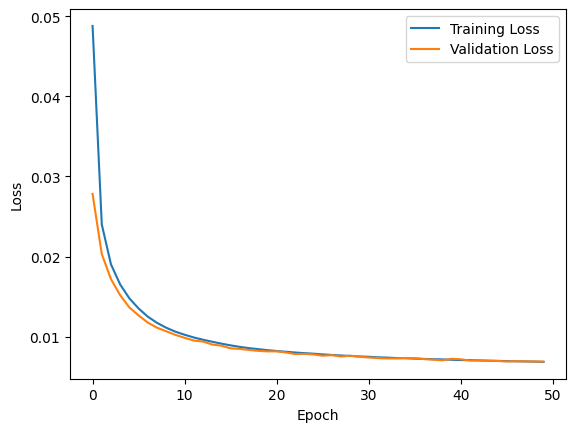

In [ ]:
### PLOT TRAINING HISTORY ###

def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [ ]:
# Evaluate the model on test data
test_loss = autoencoder.evaluate(x_test_flat, x_test_flat)
print(f"Test Loss: {test_loss:.4f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0069
Test Loss: 0.0069


1/1 [==============================] - 0s 99ms/step


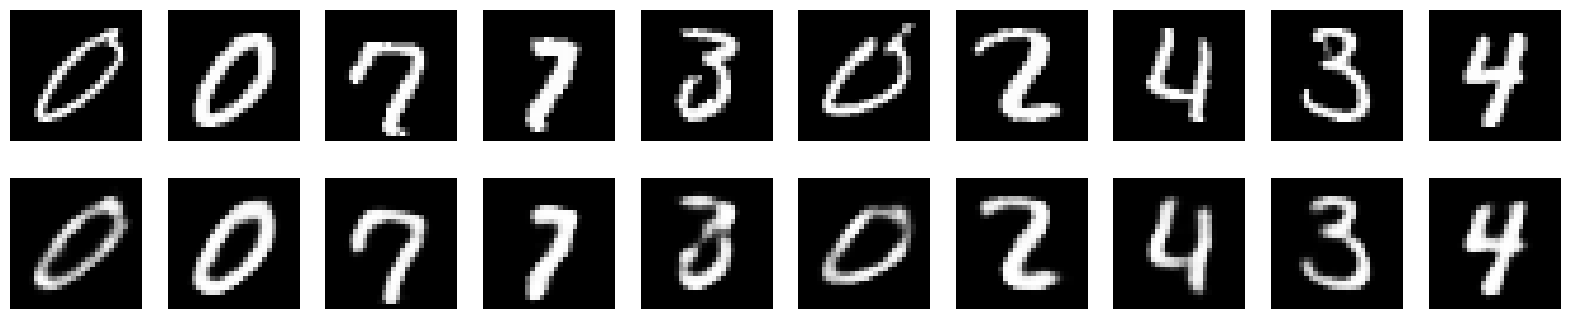

In [ ]:
### VISUALIZE RECONSTRUCTION RESULTS ###

# Select some test images to visualize reconstruction
num_images = 10
random_indices = np.random.randint(x_test.shape[0], size=num_images)
original_images = x_test[random_indices]
original_images_flat = original_images.reshape(-1, input_size)

# Predict the reconstructed images
reconstructed_images_flat = autoencoder.predict(original_images_flat)
reconstructed_images = reconstructed_images_flat.reshape(-1, 28, 28)

# Plot original and reconstructed images side by side
def plot_reconstructed_images(original, reconstructed, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original Image
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i], cmap='gray')
        plt.axis('off')

        # Reconstructed Image
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i], cmap='gray')
        plt.axis('off')
    plt.show()

plot_reconstructed_images(original_images, reconstructed_images)

CONVOLUTIONAL AUTOENCODER

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model

In [ ]:
x = Input(shape=(28, 28,1))
# Encoder
def encoder(input_layer):
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer) # Indented this line and subsequent lines within the function
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x) # Bottleneck layer
    return x

In [ ]:
# Decoder
def decoder(encoded_input):
    x = Dense(7 * 7 * 128, activation='relu')(encoded_input)
    x = Reshape((7, 7, 128))(x) # The reshape operation is applied to the output of the Dense layer
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
    return x

In [ ]:
# Define input_shape
input_shape = (28, 28, 1) # Assuming grayscale images

In [ ]:
# Build the Autoencoder model
input_layer = Input(shape=input_shape)
encoded = encoder(input_layer)
decoded = decoder(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
# Summary of the model
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         7385

In [ ]:
# Train the convolutional autoencoder
history = autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/50
469/469 [==============================] - 37s 74ms/step - loss: 0.0199 - val_loss: 0.0103
Epoch 2/50
469/469 [==============================] - 32s 69ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 3/50
469/469 [==============================] - 33s 69ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 4/50
469/469 [==============================] - 33s 70ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 5/50
469/469 [==============================] - 33s 71ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 6/50
469/469 [==============================] - 33s 71ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 7/50
469/469 [==============================] - 33s 70ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 8/50
469/469 [==============================] - 33s 70ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/50
469/469 [==============================] - 33s 69ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 10/50
469/469 [==============================] - 32s 69ms/step - loss: 0.002

In [ ]:
# Evaluate the model on test data
test_loss = autoencoder.evaluate(x_test, x_test)
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
# Select some test images to visualize reconstruction
num_images = 10
random_indices = np.random.randint(x_test.shape[0], size=num_images)
original_images = x_test[random_indices]

# Predict the reconstructed images
reconstructed_images = autoencoder.predict(original_images)

# Plot original and reconstructed images side by side
plot_reconstructed_images(original_images.reshape(-1, 28, 28), reconstructed_images.reshape(-1, 28, 28))